In [126]:
!kaggle datasets download -d deepcontractor/car-price-prediction-challenge  --unzip -f car_price_prediction.csv

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
License(s): CC0-1.0
100%|█████████████████████████████████████████| 429k/429k [00:00<00:00, 583kB/s]
100%|█████████████████████████████████████████| 429k/429k [00:00<00:00, 581kB/s]


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_theme(color_codes=True, palette="bright")

In [128]:
cars = pd.read_csv("car_price_prediction.csv", dtype={"ID": object, "Cylinder": object})

cars.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## Validation And Cleaning
Removing duplicates.
Replacing `-` with `0` in `Levy` column.
Extracting `km` from `Mileage` column and converting to integer.
Correcting `Doors` and `Wheel` values.
Replacing `Jeep` with `SUV` in `Category`.
Extracting `Turbo` from `Engine volume`.
Converting `Engine volume` to float.
Adding `Age` column.

In [129]:
print(cars.isna().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [130]:
print(f"\nNumber of duplicates: {cars.duplicated().sum()}")
cars = cars.drop_duplicates()

cars["Levy"] = cars["Levy"].map(lambda x: 0 if x == "-" else float(x))

cars["Mileage"] = cars["Mileage"].str.replace("km", "").astype(int)

cars["Doors"] = cars["Doors"].map({"04-May": 4, "02-Mar": 2, ">5": ">5"}).astype(object)

cars["Wheel"] = (
    cars["Wheel"]
    .map({"Right-hand drive": "Right-hand drive", "Left wheel": "Left-hand drive"})
    .astype(object)
)

cars["Category"] = cars["Category"].str.replace("Jeep", "SUV")

cars["Turbo"] = cars["Engine volume"].str.contains("Turbo").astype(int)
cars["Engine volume"] = cars["Engine volume"].str.replace(" Turbo", "").astype(float)


cars.head()


Number of duplicates: 313


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,45654403,13328,1399.0,LEXUS,RX 450,2010,SUV,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left-hand drive,Silver,12,0
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,SUV,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left-hand drive,Black,8,0
2,45774419,8467,0.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,0
3,45769185,3607,862.0,FORD,Escape,2011,SUV,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left-hand drive,White,0,0
4,45809263,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left-hand drive,Silver,4,0


In [131]:
cars.shape

(18924, 19)

Removing `Price` Outliers

In [132]:
price_25 = cars["Price"].quantile(0.25)
price_75 = cars["Price"].quantile(0.75)
iqr = price_75 - price_25
lower_bound = price_25 - 1.5 * iqr
upper_bound = price_75 + 1.5 * iqr
cars_cleaned = cars[(cars["Price"] > lower_bound) & (cars["Price"] < upper_bound)]
print(f"Number of outliers removed: {cars.shape[0] - len(cars_cleaned)}")

Number of outliers removed: 1055


Dropping `ID` because it is unnecessary.
`Manufacturer` and `Model` columns as their unique values will cause issues with test or train data not having the model or manufacturer hence causing errors.

In [133]:
numerical_features = cars_cleaned.drop(columns=["Price"]).select_dtypes(include=np.number)
categorical_features = (
    cars_cleaned.drop(columns=["ID", "Manufacturer", "Model", "Mileage"])
    .select_dtypes(include=object)
    .astype(str)
)
cars_prepped = pd.concat([numerical_features, categorical_features, cars_cleaned["Price"]], axis=1)
cars_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17869 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Levy              17869 non-null  float64
 1   Prod. year        17869 non-null  int64  
 2   Engine volume     17869 non-null  float64
 3   Mileage           17869 non-null  int64  
 4   Cylinders         17869 non-null  float64
 5   Airbags           17869 non-null  int64  
 6   Turbo             17869 non-null  int64  
 7   Category          17869 non-null  object 
 8   Leather interior  17869 non-null  object 
 9   Fuel type         17869 non-null  object 
 10  Gear box type     17869 non-null  object 
 11  Drive wheels      17869 non-null  object 
 12  Doors             17869 non-null  object 
 13  Wheel             17869 non-null  object 
 14  Color             17869 non-null  object 
 15  Price             17869 non-null  int64  
dtypes: float64(3), int64(5), object(8)
memory usa

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [135]:
X_train, ex, y_train, ey = train_test_split(
    cars_prepped.drop(columns=["Price"]), cars_prepped["Price"], test_size=0.2, random_state=341
)

X_val, X_test, y_val, y_test = train_test_split(
    ex, ey, test_size=0.5, random_state=341
)


Model Building

With PCA and Standardisation


In [136]:
num_transformer = Pipeline([("poly", PolynomialFeatures(degree=2)), ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features.columns.tolist()),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features.columns.tolist()),
    ]
)

lm_pipe = Pipeline([("preprocessor", preprocessor), ("pca", PCA()), ("lm", LinearRegression())])

lm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Levy', 'Prod. year',
                                                   'Engine volume', 'Mileage',
                                                   'Cylinders', 'Airbags',
                                                   'Turbo']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Category',
                                                   'Leather interior',
                                                   'Fuel type', 'Gear box type',
                                                   'Drive wheels', 'Doors',
                                                   'Wheel', 'Color'])])),
                ('pca', PCA()), ('lm', LinearRegression())])

Without PCA and Standardisation

In [137]:
num_transformer = Pipeline([("poly", PolynomialFeatures(degree=2)), #("scaler", StandardScaler())
                            ])


preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features.columns.tolist()),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features.columns.tolist()),
    ]
)

lm_pipe_wo_pca_std = Pipeline([("preprocessor", preprocessor),# ("pca", PCA()), 
                    ("lm", LinearRegression())])

lm_pipe_wo_pca_std

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures())]),
                                                  ['Levy', 'Prod. year',
                                                   'Engine volume', 'Mileage',
                                                   'Cylinders', 'Airbags',
                                                   'Turbo']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Category',
                                                   'Leather interior',
                                                   'Fuel type', 'Gear box type',
                                                   'Drive wheels', 'Doors',
                                                   'Wheel', 'Color'])])),
                ('lm', LinearRegression())])

Without PCA 

In [138]:
num_transformer = Pipeline([("poly", PolynomialFeatures(degree=2)), ("scaler", StandardScaler())])


preprocessor = ColumnTransformer(
    [
        ("numerical", num_transformer, numerical_features.columns.tolist()),
        ("categorical", OneHotEncoder(sparse_output=False), categorical_features.columns.tolist()),
    ]
)

lm_pipe_wo_pca = Pipeline([("preprocessor", preprocessor),# ("pca", PCA()), 
                    ("lm", LinearRegression())])

lm_pipe_wo_pca

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Levy', 'Prod. year',
                                                   'Engine volume', 'Mileage',
                                                   'Cylinders', 'Airbags',
                                                   'Turbo']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Category',
                                                   'Leather interior',
                                                   'Fuel type', 'Gear box type',
                                                   'Drive wheels', 'Doors',
                                                   'Wheel', 'Color'])])),
                ('lm', LinearRegression())])

In [139]:
lm_pipe.fit(X_train, y_train)
lm_pipe_wo_pca_std.fit(X_train, y_train)
lm_pipe_wo_pca.fit(X_train, y_train)

preds = lm_pipe.predict(X_val)
preds_wo_pca_std = lm_pipe_wo_pca_std.predict(X_val)
preds_wo_pca = lm_pipe_wo_pca.predict(X_val)


With PCA and Standardisation

In [140]:
print(f"r2_score: {r2_score(y_val, preds):.2f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.2f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.2f}")

r2_score: 0.35
RMSE: 8861.45
MAE: 6673.68


Without PCA and Standardisation

In [141]:
print(f"r2_score: {r2_score(y_val, preds_wo_pca_std):.2f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds_wo_pca_std):.2f}")
print(f"MAE: {mean_absolute_error(y_val, preds_wo_pca_std):.2f}")

r2_score: 0.14
RMSE: 10228.12
MAE: 7775.86


Without PCA

In [142]:
print(f"r2_score: {r2_score(y_val, preds_wo_pca):.2f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds_wo_pca):.2f}")
print(f"MAE: {mean_absolute_error(y_val, preds_wo_pca):.2f}")

r2_score: 0.35
RMSE: 8869.79
MAE: 6739.22


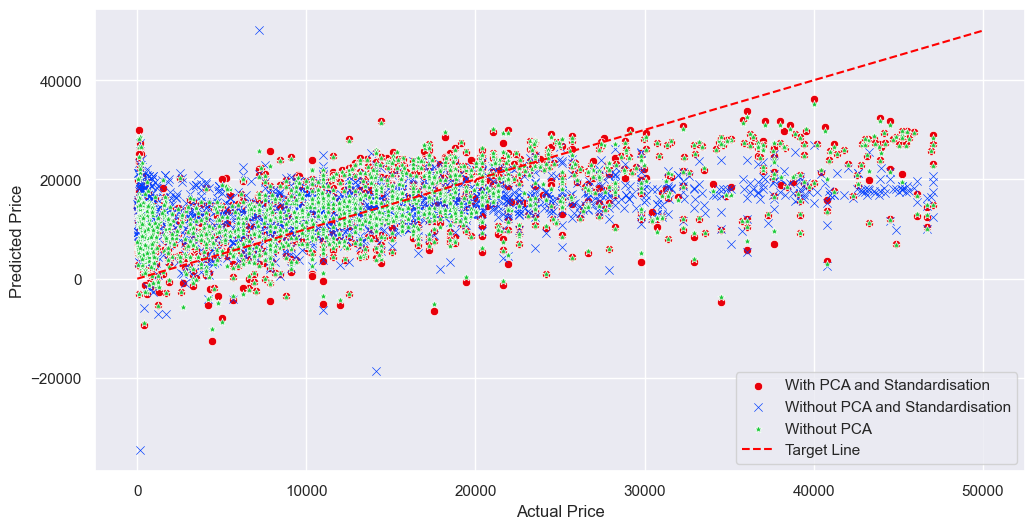

In [143]:
resid = pd.DataFrame({"Actual": y_val, "Predicted_with_pca_std": preds, "Predicted_wo_pca_std": preds_wo_pca_std, "Predicted_wo_pca": preds_wo_pca})
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Actual", y="Predicted_with_pca_std", data=resid, marker="o", c="r", label="With PCA and Standardisation")
sns.scatterplot(x="Actual", y="Predicted_wo_pca_std", data=resid, marker="x", c="b", label="Without PCA and Standardisation")
sns.scatterplot(x="Actual", y="Predicted_wo_pca", data=resid, marker="*", c="g", label="Without PCA")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0, 50000], [0, 50000], color="red", linestyle="--", label="Target Line")
plt.legend()
plt.show()

Best Model: With PCA and Standardisation


In [144]:
predictions = lm_pipe.predict(X_test)
print(f"r2_score: {r2_score(y_test, predictions):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, predictions):.2f}")
print(f"MAE: {mean_absolute_error(y_test, predictions):.2f}")

r2_score: 0.36
RMSE: 9361.36
MAE: 6889.24


In [145]:
resid = pd.DataFrame({"Actual": y_test, "Predicted": predictions, "Residual": y_test - predictions})

Residuals Distribution & Comparison to Actuals

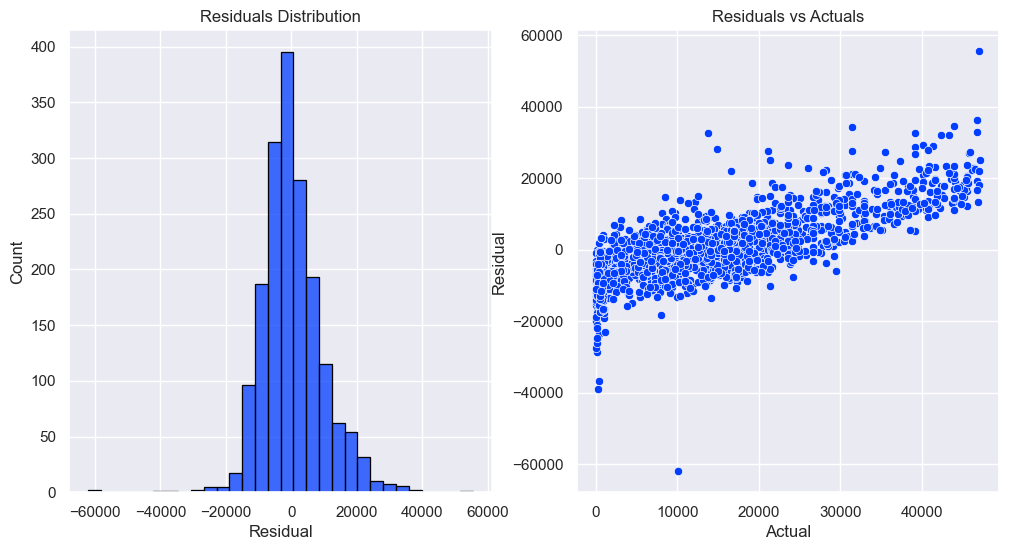

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(resid["Residual"], ax=ax[0], bins=30, edgecolor="black")
ax[0].set_title("Residuals Distribution")
sns.scatterplot(x="Actual", y="Residual", data=resid, ax=ax[1])
ax[1].set_title("Residuals vs Actuals")
plt.show()